# Electron Laboratory (Materials)
A notebook to debug and test the performance of the electron routines.

**27 June 2020**: 
- Materials module took **30.6647365s** to load.
- Materials module took **6.302707799999993s** to load.

In [1]:
import time

t0 = time.perf_counter()
from materials import *
tf = time.perf_counter()

print(f"Materials module took {tf-t0}s to load.")

> Imported materials!
Materials module took 6.3415339s to load.


In [2]:
t0 = time.perf_counter()
material = Material("Water")
tf = time.perf_counter()

print(f"Material object took {tf-t0}s to make.")

ee   = material.electron

el = material.electron.elastic
br = material.electron.brem

Material object took 0.48947949999999985s to make.


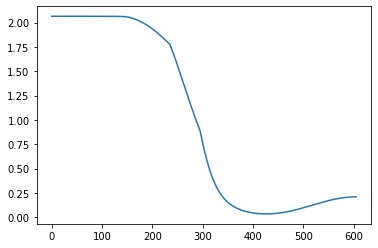

In [3]:
from scipy.integrate import quad
from matplotlib.pyplot import *

el.update_dist(1e2)
plot(el.prob)

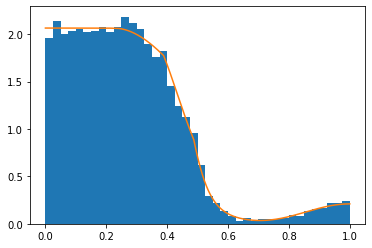

In [4]:
from numpy.random import *
samples = [el.invCum(rand()) for _ in range(10000)]

hist(samples, bins=40, density=True);
plot(el.xAxis, el.prob)
#plot(el.prob);

The time it takes to create a material object will only increase. I should start saving them.

In [11]:
from numpy import *
from numpy.random import rand
from matplotlib.pyplot import *
%matplotlib inline

## Inverse Mean Free Paths

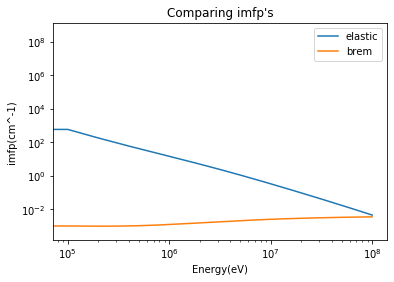

In [12]:
#elastic scattering inverse mean free path
E = arange(0, 100e6, 100e3)
imfp = [el(energy) for energy in E]
plot(E, imfp)

#bremsstraugh inverse mean free path
plot(E, br(E))
legend(['elastic', 'brem'])
yscale('log'); xscale('log');

title("Comparing imfp's"); xlabel('Energy(eV)'), ylabel('imfp(cm^-1)');

# RITA Method

Rational Inverse Transform with Aliasing.

In [26]:
from numpy import *
from numpy.random import *
from scipy.interpolate import CubicSpline, RectBivariateSpline
from scipy.integrate import quad
from matplotlib.pyplot import *

Normally, the probability distribution is obtained from numerical tables using cubic interpolation. But here I'm just going to use the Rayleigh prob distribution.

In [63]:
#accidently deleted this cell.....

I'm going to evaluate the cumulutative function at each point in this grid.

In [25]:
cum_eval = [cum(x)[0] for x in gridX]
print(cum_eval)

[0.0, 0.031804476054284984, 0.06345019465517203, 0.09477998460125939, 0.12563983134583176, 0.15588041585930104, 0.1853586065755913, 0.21393888951543413, 0.2414947222972546, 0.2679097985068185, 0.29307920979247754, 0.3169104940747412, 0.3393245593968109, 0.3602564741852676, 0.3796561160248909, 0.39748867246526265, 0.41373498885526455, 0.42839175973002036, 0.44147156183800834, 0.4530027284783477, 0.46302906640383945, 0.4716094181183732, 0.47881707394207923, 0.4847390397186755, 0.48947516748183845, 0.49313715776668876, 0.49584744353496757, 0.49773796686535415, 0.49894886063182986, 0.4996270483423225, 0.49992477612758246, 0.4999980915481698, 0.500005284418811, 0.500105305228895, 0.5004561769617242, 0.5012134161811015, 0.5025284791612313, 0.5045472485856926, 0.5074085759358874, 0.5112428941329357, 0.5161709142950442, 0.5223024196319148, 0.5297351685272016, 0.538553917769058, 0.5488295756883247, 0.5606184936659273, 0.5739619030885069, 0.5888855033780317, 0.6053992052116701, 0.623497031497578

Now, inverting the cumul function is a matter of changing the order of the inputs:

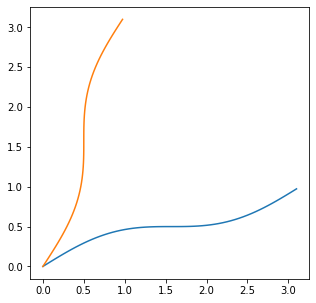

In [28]:
figure(figsize=(5,5))
plot(gridX, cum_eval)
plot(cum_eval, gridX)

The RITA method is used in several places throughout the code. It is therefore, very likely that the class 'Distribution' will become its own tool. As of 28 June it looks like this:

In [28]:
class Distribution: #RITA method
    def __init__(self, xAxis = [], yAxisCol = [], E = []):
        """Normalizes the distributions. Interpolates the probability distribution.
        Calculates and interpolates the inverse cumulutative function on the provided grid 'xAxis'.
        
        Usage:
        > x = arange(0, 1, .1)
        > energy = arange(0, 50)
        > probList = [prob1, prob2, prob3, ..., prob50]
        
        > dist = Distribution(xAxis = x, E = energy, yAxisCol = probList)
        
        This will perform all operations and store them in memory.
        To get the distribution, one must update the state by giving an energy value:
        
        > dist.update_dist(1e6)
        
        This will perform aliasing according to a log interpolation in E and update
        the state, i.e. dist.prob and dist.invCum are available(and callable).
        """
        #note: yCol = Collection of y's
        
        assert len(E) == len(yAxisCol)
        assert len(xAxis) == len(yAxisCol[0])
        
        #note: yAxis is an array of arrays with len(E)
        E, xAxis, yAxisCol = map(array, [E, xAxis, yAxisCol])
        
        #Normalize table of probabilities with cubic interpolation
        dcsCol       = [CubicSpline(xAxis, yAxis) for yAxis in yAxisCol]
        adhocCS      = [dcs.integrate(0, 1) for dcs in dcsCol]
        self.probCol = [yAxis/cs for cs, yAxis in zip(adhocCS, yAxisCol)]
        self.probCol = array(self.probCol)


        #construct table of cumul values for each energy in the grid
        self.probCol = [       CubicSpline(xAxis, prob)       for prob in self.probCol]
        self.cumCol  = [[prob.integrate(0, x) for x in xAxis] for prob in self.probCol]
        
        self.invCumCol = [interp1d(cum, xAxis) for cum in self.cumCol] #future: change to rational
        #it's inverted cuz I changed the order of the inputs
        

        
        
    def update_dist(self, E):
        """Update distributions according to energy."""
        
        k = searchsorted(self.E, E, side='left')
        Ek, Ek_ = self.E[k-1], self.E[k]
        pr = (log(Ek_) - log(E))/(log(Ek_) - log(Ek))
        
        if rand() < pr: k -= 1
            
        self.prob   = self.probCol[k]
        self.invCum = self.invCumCol[k]

There is obviously a long way to go in terms of readability. Despite its frequent use, this code is having a hard time finding its place. For example, if I am to use it to implement the random hinge method, it is not favourably to use 'Distribution.invCum' to obtain $\mu_c$, since this function actually performs a sampling on which '_invCum[k]' to return. This means that the information about state is lost, and I would have to retrieve '

# Elastic Scattering

Text(0.5, 1.0, 'to do: better plots, subplot energy ranges')

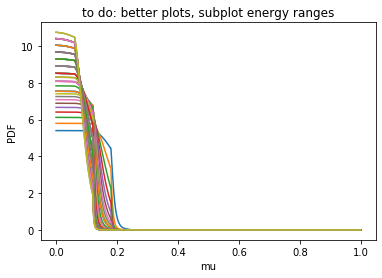

In [13]:
#cum    = el.cum
invCum = el.invCum

mu = arange(0, 1, .001)

E = 1e6
for E in arange(1e6, 50e6, 1e6):
    prob = el.prob(E)
    Y    = [prob(x) for x in mu]
    plot(mu, Y); 

xlabel("mu"); ylabel("PDF"); title("to do: better plots, subplot energy ranges")

In [25]:
from numpy.random import rand
import time

N = 500_000
invCum = el.invCum
sample = []

t0 = time.perf_counter()
for _ in range(N):
    invCumE = invCum(1e6)
    sample.append(invCumE(rand()))
tf = time.perf_counter()

print(f"{N} samples took {tf-t0}s.")
print(f"An average of {N/(tf-t0)} samples per sec.")
print(f"Conversly, 1 sample took {(tf-t0)/N} seconds.")

500000 samples took 110.3876373000021s.
An average of 4529.49272427258 samples per sec.
Conversly, 1 sample took 0.0002207752746000042 seconds.


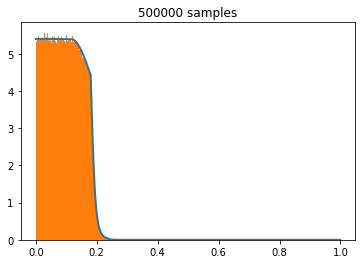

In [26]:
prob = el.prob(1e6)
Y    = [prob(x) for x in mu]
plot(mu, Y, lw=2); 

hist(sample, density = True, bins = 100); title(f"{N} samples");

**checks out**

#### TO BE CONTINUED

In [40]:
help(hist)

Help on function hist in module matplotlib.pyplot:

hist(x, bins=None, range=None, density=None, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, normed=None, *, data=None, **kwargs)
    Plot a histogram.
    
    Compute and draw the histogram of *x*.  The return value is a tuple
    (*n*, *bins*, *patches*) or ([*n0*, *n1*, ...], *bins*, [*patches0*,
    *patches1*,...]) if the input contains multiple data.  See the
    documentation of the *weights* parameter to draw a histogram of
    already-binned data.
    
    Multiple data can be provided via *x* as a list of datasets
    of potentially different length ([*x0*, *x1*, ...]), or as
    a 2-D ndarray in which each column is a dataset.  Note that
    the ndarray form is transposed relative to the list form.
    
    Masked arrays are not supported at present.
    
    Parameters
    ----------
    x : (n,) array or seque

## Elastic Hinge

In [53]:
el = ee.elastic
el.F

<bound method Elastic.F of <electron.Elastic object at 0x0000017BDE17B8C8>>

In [54]:
help(el.F)

Help on method F in module electron:

F(mu_c, E, s) method of electron.Elastic instance
    Simplified probability distribution for the polar displacement of a random hinge. Returns a and b.



In [3]:
a, b = el.F(el.mu_c(1e6), 1e6, 4)
print(a, b)

0.8211339959393724 0.35511937724254844


In [4]:
F_fixedE = lambda s: el.F(el.mu_c(1e6), 1e6, s)
S = arange(0, 50, .1)
F = [F_fixedE(s) for s in S]
plot(S, F); xlabel('Distance(cm)');
legend(['parameter a', 'parameter b'])

NameError: name 'plot' is not defined

~However, obtaining 'a' and 'b' is time consuming. The following probably looks alright, but this is because I relaxed the error tolerance on the 'quad' function.~

**Warning**: I have relaxed the epsabs of the quad functions.

I have also moved the calculation of $<\mu>$ and $<\mu^2>$ to the initialization time. The integrals are calculated for a grid of $\mu_c$ and then interpolated. This process is frutuitous:

In [6]:
import time

N = 10000
el.update_dist(1e6)
t0 = time.perf_counter()
for _ in range(N):
    a, b = el.F(el.mu_c(), 4);
tf = time.perf_counter()

print(f"{N} samples took {tf-t0}s.")
print(f"An average of {N/(tf-t0)} samples per sec.")
print(f"Conversly, 1 sample took {(tf-t0)/N} seconds.")

10000 samples took 8.122325099999998s.
An average of 1231.1745561624962 samples per sec.
Conversly, 1 sample took 0.0008122325099999998 seconds.


Old output:

    100 samples took 11.828894100000014s.
    An average of 8.453875667041427 samples per sec.
    Conversly, 1 sample took 0.11828894100000013 seconds.
    
This is more or less what it looks like with strict error tolerances and with $<\mu>$ and $<\mu^2>$ calculated at *collision time*.

In [2]:
from numpy import array
x = array([[1, 1], [1, 1]])

In [3]:
y = array([3, 2])

In [4]:
x*y

array([[3, 2],
       [3, 2]])

In [5]:
from scipy.integrate import quad

In [6]:
help(quad)

Help on function quad in module scipy.integrate.quadpack:

quad(func, a, b, args=(), full_output=0, epsabs=1.49e-08, epsrel=1.49e-08, limit=50, points=None, weight=None, wvar=None, wopts=None, maxp1=50, limlst=50)
    Compute a definite integral.
    
    Integrate func from `a` to `b` (possibly infinite interval) using a
    technique from the Fortran library QUADPACK.
    
    Parameters
    ----------
    func : {function, scipy.LowLevelCallable}
        A Python function or method to integrate.  If `func` takes many
        arguments, it is integrated along the axis corresponding to the
        first argument.
    
        If the user desires improved integration performance, then `f` may
        be a `scipy.LowLevelCallable` with one of the signatures::
    
            double func(double x)
            double func(double x, void *user_data)
            double func(int n, double *xx)
            double func(int n, double *xx, void *user_data)
    
        The ``user_data`` is the 

In [1]:
from scipy.integrate import *
help(quadrature)

Help on function quadrature in module scipy.integrate.quadrature:

quadrature(func, a, b, args=(), tol=1.49e-08, rtol=1.49e-08, maxiter=50, vec_func=True, miniter=1)
    Compute a definite integral using fixed-tolerance Gaussian quadrature.
    
    Integrate `func` from `a` to `b` using Gaussian quadrature
    with absolute tolerance `tol`.
    
    Parameters
    ----------
    func : function
        A Python function or method to integrate.
    a : float
        Lower limit of integration.
    b : float
        Upper limit of integration.
    args : tuple, optional
        Extra arguments to pass to function.
    tol, rtol : float, optional
        Iteration stops when error between last two iterates is less than
        `tol` OR the relative change is less than `rtol`.
    maxiter : int, optional
        Maximum order of Gaussian quadrature.
    vec_func : bool, optional
        True or False if func handles arrays as arguments (is
        a "vector" function). Default is True.
  

In [8]:
def f(x):
    return x**2

In [26]:
import time
t0 = time.perf_counter()
for _ in range(10000):
    res = quad(f, 0, 1)
tf = time.perf_counter()

print(f"took {tf-t0}")
print(res)

took 0.36660230000006777
(0.33333333333333337, 3.700743415417189e-15)


In [28]:
import time
t0 = time.perf_counter()
for _ in range(10000):
    res = quadrature(f, 0, 1, tol=1.49e-01, rtol=1.49e-01, maxiter=1)
tf = time.perf_counter()

print(f"took {tf-t0}")
print(res)

took 2.1636171000000104
(0.33333333333333337, 0.08333333333333337)


In [30]:
help(romb)

Help on function romb in module scipy.integrate.quadrature:

romb(y, dx=1.0, axis=-1, show=False)
    Romberg integration using samples of a function.
    
    Parameters
    ----------
    y : array_like
        A vector of ``2**k + 1`` equally-spaced samples of a function.
    dx : float, optional
        The sample spacing. Default is 1.
    axis : int, optional
        The axis along which to integrate. Default is -1 (last axis).
    show : bool, optional
        When `y` is a single 1-D array, then if this argument is True
        print the table showing Richardson extrapolation from the
        samples. Default is False.
    
    Returns
    -------
    romb : ndarray
        The integrated result for `axis`.
    
    See also
    --------
    quad : adaptive quadrature using QUADPACK
    romberg : adaptive Romberg quadrature
    quadrature : adaptive Gaussian quadrature
    fixed_quad : fixed-order Gaussian quadrature
    dblquad : double integrals
    tplquad : triple integrals

In [31]:
help(romberg )

Help on function romberg in module scipy.integrate.quadrature:

romberg(function, a, b, args=(), tol=1.48e-08, rtol=1.48e-08, show=False, divmax=10, vec_func=False)
    Romberg integration of a callable function or method.
    
    Returns the integral of `function` (a function of one variable)
    over the interval (`a`, `b`).
    
    If `show` is 1, the triangular array of the intermediate results
    will be printed.  If `vec_func` is True (default is False), then
    `function` is assumed to support vector arguments.
    
    Parameters
    ----------
    function : callable
        Function to be integrated.
    a : float
        Lower limit of integration.
    b : float
        Upper limit of integration.
    
    Returns
    -------
    results  : float
        Result of the integration.
    
    Other Parameters
    ----------------
    args : tuple, optional
        Extra arguments to pass to function. Each element of `args` will
        be passed as a single argument to `fun

In [33]:
help(simps)

Help on function simps in module scipy.integrate.quadrature:

simps(y, x=None, dx=1, axis=-1, even='avg')
    Integrate y(x) using samples along the given axis and the composite
    Simpson's rule.  If x is None, spacing of dx is assumed.
    
    If there are an even number of samples, N, then there are an odd
    number of intervals (N-1), but Simpson's rule requires an even number
    of intervals.  The parameter 'even' controls how this is handled.
    
    Parameters
    ----------
    y : array_like
        Array to be integrated.
    x : array_like, optional
        If given, the points at which `y` is sampled.
    dx : int, optional
        Spacing of integration points along axis of `y`. Only used when
        `x` is None. Default is 1.
    axis : int, optional
        Axis along which to integrate. Default is the last axis.
    even : str {'avg', 'first', 'last'}, optional
        'avg' : Average two results:1) use the first N-2 intervals with
                  a trapezoidal 

In [34]:
help(cumtrapz )

Help on function cumtrapz in module scipy.integrate.quadrature:

cumtrapz(y, x=None, dx=1.0, axis=-1, initial=None)
    Cumulatively integrate y(x) using the composite trapezoidal rule.
    
    Parameters
    ----------
    y : array_like
        Values to integrate.
    x : array_like, optional
        The coordinate to integrate along.  If None (default), use spacing `dx`
        between consecutive elements in `y`.
    dx : float, optional
        Spacing between elements of `y`.  Only used if `x` is None.
    axis : int, optional
        Specifies the axis to cumulate.  Default is -1 (last axis).
    initial : scalar, optional
        If given, insert this value at the beginning of the returned result.
        Typically this value should be 0.  Default is None, which means no
        value at ``x[0]`` is returned and `res` has one element less than `y`
        along the axis of integration.
    
    Returns
    -------
    res : ndarray
        The result of cumulative integration

In [5]:
from numpy import *
from scipy.integrate import *
x = array([0, 1, 2, 3, 4])
cumtrapz(x**2, x=x)

array([ 0.5,  3. ,  9.5, 22. ])

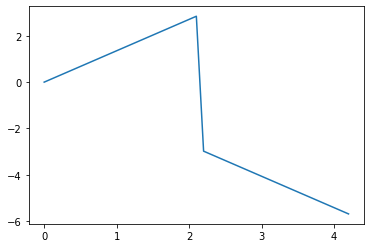

In [25]:
plot(X, Y)

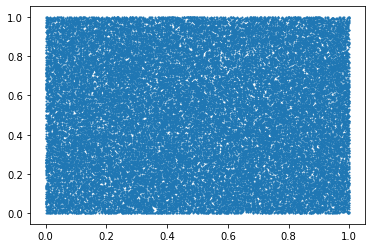

In [39]:
from numpy.random import rand
from numpy import arange

a, b = 4.21, 5.7
m    = b/a

def f(x):
    return m*x

numero_de_propostas = 50_000


X = [rand() for _ in range(numero_de_propostas)]
Y = [rand() for _ in range(numero_de_propostas)]

scatter(X, Y, s = 1)

In [34]:
[x for x in range(6)]

[0, 1, 2, 3, 4, 5]

In [35]:
[x**2 for x in range(5)]

[0, 1, 4, 9, 16]

Text(0, 0.5, 'f(x)')

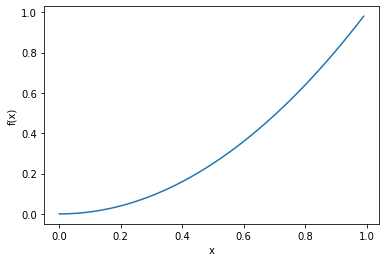

In [58]:
from numpy.random import rand
from numpy import arange
from matplotlib.pyplot import *

def f(x):
    return x**2

x0, xf, dx = 0, 1, 0.01
X = arange(x0, xf, dx)

plot(X, f(X))
xlabel('x'); ylabel('f(x)')

In [57]:
numero_de_amostras = 5_000_000
amostra_X = [rand() for _ in range(numero_de_amostras)]
amostra_Y = [rand() for _ in range(numero_de_amostras)]


#scatter(amostra_X, amostra_Y, s = 1)
#plot(X, f(X), lw = 2, color = (1, 0, 0))

In [54]:
amostras_aceites = []
amostras_aceites_X = []
amostras_aceites_Y = []

for x, y in zip(amostra_X, amostra_Y):
    if y < f(x):
        amostras_aceites.append(ponto)
        amostras_aceites_X.append(x)
        amostras_aceites_Y.append(y)

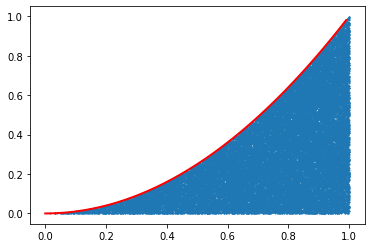

In [50]:
plot(X, f(X), lw = 2, color = (1, 0, 0))
scatter(amostras_aceites_X, amostras_aceites_Y, s = 1)

In [55]:
area_f = len(amostras_aceites)/numero_de_amostras
print("Área = ", area_f)

Área =  0.332692


In [52]:
1/3

0.3333333333333333

In [47]:
import sympy as sy
x = sy.Symbol('x')
sy.integrate(f(x), (x, 0, 1))

1/3

In [ ]:
scatter(amostra_X, amostra_Y, s = 1)
plot(X, f(X), lw = 2, color = (1, 0, 0))

In [21]:
amostra_X = []
amostra_Y = []

for _ in range (numero_de_amostras):
    amostra_X.append(rand())
    amostra_Y.append(rand())


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [22]:
print(amostra_Y)

[0.8265768740692491, 0.6554624706437806, 0.8640453319041258, 0.20661367104322192, 0.9584665597840375, 0.7375013022173897, 0.8053668274989467, 0.018591497117684708, 0.44985302976010877, 0.7804741244564776, 0.950960331391358, 0.1806868387293179, 0.1305890963741556, 0.7286614461180626, 0.8413061120255744, 0.8615888540396308, 0.8635674686637683, 0.39531527850881243, 0.08909148450840021, 0.4985936856260714, 0.7178017109556525, 0.033896982344429394, 0.3888512110958725, 0.8390853271400502, 0.870977291660392, 0.26876982563883856, 0.8408974043165028, 0.6197380892540542, 0.9912709051624966, 0.2015550034924405, 0.8608782151439743, 0.9853488367828022, 0.4514777061311521, 0.06943101532595941, 0.6534044397913681, 0.22283971685102866, 0.4478978960714547, 0.9588763786020654, 0.3946178371723611, 0.3392226354099348, 0.8271043161765321, 0.7947077740241429, 0.5710518312730668, 0.43849752276498755, 0.7645492788862692, 0.46493888990057575, 0.08731734922776768, 0.8736771635891495, 0.6718931057155256, 0.52935